# Ejemplo MNIST

Trabajando este ejemplo: https://lux.csail.mit.edu/stable/tutorials/beginner/4_SimpleChains

In [3]:
using Lux, MLUtils, Optimisers, Zygote, OneHotArrays, Random, Statistics, Printf, Reactant
using MLDatasets: MNIST
using SimpleChains: SimpleChains

Reactant.set_default_backend("cpu")

AssertionError("Could not find registered platform with name: \"cuda\". Available platform names are: ")


In [ ]:
function loadmnist(batchsize, train_split)
    # Load MNIST
    N = parse(Bool, get(ENV, "CI", "false")) ? 1500 : nothing
    dataset = MNIST(; split=:train)
    if N !== nothing
        imgs = dataset.features[:, :, 1:N]
        labels_raw = dataset.targets[1:N]
    else
        imgs = dataset.features
        labels_raw = dataset.targets
    end

    # Process images into (H, W, C, BS) batches
    x_data = Float32.(reshape(imgs, size(imgs, 1), size(imgs, 2), 1, size(imgs, 3))) # (28,28,N))-->(28,28,1,N)
    y_data = onehotbatch(labels_raw, 0:9) # Probablemente manda la categoria a onehot encoding.
    (x_train, y_train), (x_test, y_test) = splitobs((x_data, y_data); at=train_split) # Split the data into training and test sets

    return (
        # Use DataLoader to automatically minibatch and shuffle the data
        DataLoader(collect.((x_train, y_train)); batchsize, shuffle=true, partial=false), # Pendiente ver si en cada llamada los manda en diferente orden
        # Don't shuffle the test data
        DataLoader(collect.((x_test, y_test)); batchsize, shuffle=false, partial=false),
    )
end

loadmnist (generic function with 1 method)

In [ ]:
lux_model = Chain(
    Conv((5, 5), 1 => 6, relu), # Pendiente ver que es el 1==>6
    MaxPool((2, 2)),
    Conv((5, 5), 6 => 16, relu),
    MaxPool((2, 2)),
    FlattenLayer(3), # El resultado de esta capa debe ser un vector de 256 elementos
    Chain(Dense(256 => 128, relu), Dense(128 => 84, relu), Dense(84 => 10)),
) # La función de activación final es softmax, pero no está explicita y se trabaja directamente con los logits.

Chain(
    layer_1 = Conv((5, 5), 1 => 6, relu),  # 156 parameters
    layer_2 = MaxPool((2, 2)),
    layer_3 = Conv((5, 5), 6 => 16, relu),  # 2_416 parameters
    layer_4 = MaxPool((2, 2)),
    layer_5 = FlattenLayer{Static.StaticInt{3}}(static(3)),
    layer_6 = Chain(
        layer_1 = Dense(256 => 128, relu),  # 32_896 parameters
        layer_2 = Dense(128 => 84, relu),  # 10_836 parameters
        layer_3 = Dense(84 => 10),      # 850 parameters
    ),
)         # Total: 47_154 parameters,
          #        plus 0 states.

## Para entender un poco mas que reciben y que regresan las capas:

In [34]:
using Lux, Random

# Define the Conv layer
layer = Conv((5, 5), 1 => 6, relu)

# Initialize the parameters and state
rng = Random.default_rng()
ps, st = Lux.setup(rng, layer)

# Create a dummy input tensor
dummy_input = rand(Float32, 28, 28, 1, 1)  # Shape: (H, W, C, BatchSize)

# Call the layer with the input, parameters, and state
output = layer(dummy_input, ps, st)

println("Output size: ", size(output))

MethodError: MethodError: no method matching size(::Tuple{Array{Float32, 4}, @NamedTuple{}})
The function `size` exists, but no method is defined for this combination of argument types.
You may need to implement the `length` method or define `IteratorSize` for this type to be `SizeUnknown`.

Closest candidates are:
  size(::Tuple, !Matched::Integer)
   @ Base tuple.jl:29
  size(!Matched::Plots.EmptyLayout)
   @ Plots ~/.julia/packages/Plots/Ec1L1/src/layouts.jl:181
  size(!Matched::BitVector)
   @ Base bitarray.jl:104
  ...


### Para crear el modelo también en simple chains:

In [9]:
adaptor = ToSimpleChainsAdaptor((28, 28, 1))
simple_chains_model = adaptor(lux_model)

SimpleChainsLayer(
    Chain(
        layer_1 = Conv((5, 5), 1 => 6, relu),  # 156 parameters
        layer_2 = MaxPool((2, 2)),
        layer_3 = Conv((5, 5), 6 => 16, relu),  # 2_416 parameters
        layer_4 = MaxPool((2, 2)),
        layer_5 = FlattenLayer{Static.StaticInt{3}}(static(3)),
        layer_6 = Chain(
            layer_1 = Dense(256 => 128, relu),  # 32_896 parameters
            layer_2 = Dense(128 => 84, relu),  # 10_836 parameters
            layer_3 = Dense(84 => 10),  # 850 parameters
        ),
    ),
)         # Total: 47_154 parameters,
          #        plus 0 states.

In [ ]:
const lossfn = CrossEntropyLoss(; logits=Val(true)) # const se usa para decirle a Julia que el tipo de la variable global no va a cambiar: https://docs.julialang.org/en/v1/base/base/#const

function accuracy(model, ps, st, dataloader)
    total_correct, total = 0, 0
    st = Lux.testmode(st) # Se configura el modelo para hacer inferencia.
    for (x, y) in dataloader
        target_class = onecold(Array(y)) # Es tomar el elemento con mayor probabilidad. Equivalentemente es softmax con temperature cero.
        predicted_class = onecold(Array(first(model(x, ps, st)))) # Es tomar el elemento con mayor probabilidad. Equivalentemente es softmax con temperature cero.
        total_correct += sum(target_class .== predicted_class)
        total += length(target_class)
    end
    return total_correct / total
end

accuracy (generic function with 1 method)

## Función para entrenar

In [6]:
fieldnames(Adam)

(:eta, :beta, :epsilon)

In [ ]:
function train(model, dev=cpu_device(); rng=Random.default_rng(), kwargs...)
    train_dataloader, test_dataloader = dev(loadmnist(128, 0.9))
    ps, st = dev(Lux.setup(rng, model)) # se inicializan los parámetros del modelo de forma aleatoria y se cargan en el CPU (dev)

    vjp = dev isa ReactantDevice ? AutoEnzyme() : AutoZygote() # Usando Reactant permite compilar el modelo antes de entrenarlo: https://lux.csail.mit.edu/stable/manual/compiling_lux_models#reactant-compilation

    train_state = Training.TrainState(model, ps, st, Adam(3.0f-4)) 

    if dev isa ReactantDevice
        x_ra = first(test_dataloader)[1]
        model_compiled = @compile model(x_ra, ps, Lux.testmode(st)) # Justo aquí es compilado el modelo
    else
        model_compiled = model
    end

    ### Lets train the model
    nepochs = 10 # Cuantas veces se pasa por todos los datos
    tr_acc, te_acc = 0.0, 0.0 # Se inicializan las variables de accuracy
    for epoch in 1:nepochs
        stime = time()
        for (x, y) in train_dataloader # Dos preguntas: x y y ya son arreglos o son otro objeto? y en cada evaluación se reordenan?
            _, _, _, train_state = Training.single_train_step!(
                vjp, lossfn, (x, y), train_state
            )
        end
        ttime = time() - stime

        tr_acc =
            accuracy(
                model_compiled, train_state.parameters, train_state.states, train_dataloader
            ) * 100
        te_acc =
            accuracy(
                model_compiled, train_state.parameters, train_state.states, test_dataloader
            ) * 100

        @printf "[%2d/%2d] \t Time %.2fs \t Training Accuracy: %.2f%% \t Test Accuracy: \
                 %.2f%%\n" epoch nepochs ttime tr_acc te_acc
    end

    return train_state.parameters, train_state.states, tr_acc, te_acc # En el código del tutorial no están las primeras dos variables, lo modifiqué para que nos devuelva los parámetros entrenados.
end

train (generic function with 2 methods)

In [12]:
@doc Training.single_train_step!

```
single_train_step!(backend, obj_fn::F, data, ts::TrainState; return_gradients=True())
```

Perform a single training step. Computes the gradients using [`compute_gradients`](@ref) and updates the parameters using [`apply_gradients!`](@ref). All backends supported via [`compute_gradients`](@ref) are supported here.

## Keyword Arguments

  * `return_gradients`: If `True()`, the gradients are returned. If `False()`, the returned gradients are `nothing`. Defaults to `True()`. This is only used for Reactant Backend.

## Return

Returned values are the same as [`compute_gradients`](@ref). Note that despite the `!`, only the parameters in `ts` are updated inplace. Users should be using the returned `ts` object for further training steps, else there is no caching and performance will be suboptimal (and absolutely terrible for backends like `AutoReactant`).


In [ ]:
ENV["DATADEPS_ALWAYS_ACCEPT"] = "true" # Se necesita al correr la primera vez para bajar los datos de MNIST
tr_acc, te_acc = train(lux_model, reactant_device()); # entrenando el modelo en lux, este tarda más

 todo inst:   %10 = addrspacecast { { i64 }, {} addrspace(10)*, {} addrspace(10)* }* %9 to { { i64 }, {} addrspace(10)*, {} addrspace(10)* } addrspace(11)*, !dbg !333
 todo inst:   %.fca.0.0.gep5 = getelementptr inbounds { { i64 }, {} addrspace(10)*, {} addrspace(10)* }, { { i64 }, {} addrspace(10)*, {} addrspace(10)* }* %9, i64 0, i32 0, i32 0, !dbg !333
 todo inst:   store i64 %.fca.0.0.extract4, i64* %11, align 8, !dbg !333, !noalias !340
 todo inst:   %18 = addrspacecast { [2 x {} addrspace(10)*], [2 x {} addrspace(10)*], [3 x [2 x {} addrspace(10)*]] }* %17 to { [2 x {} addrspace(10)*], [2 x {} addrspace(10)*], [3 x [2 x {} addrspace(10)*]] } addrspace(11)*, !dbg !333
 todo inst:   %.fca.0.0.gep = getelementptr inbounds { [2 x {} addrspace(10)*], [2 x {} addrspace(10)*], [3 x [2 x {} addrspace(10)*]] }, { [2 x {} addrspace(10)*], [2 x {} addrspace(10)*], [3 x [2 x {} addrspace(10)*]] }* %17, i64 0, i32 0, i64 0, !dbg !333
 todo inst:   store {} addrspace(10)* %.fca.0.0.extract, {}

[ 1/10] 	 Time 93.26s 	 Training Accuracy: 93.78% 	 Test Accuracy: 95.06%
[ 2/10] 	 Time 1.37s 	 Training Accuracy: 96.52% 	 Test Accuracy: 96.96%
[ 3/10] 	 Time 1.55s 	 Training Accuracy: 97.23% 	 Test Accuracy: 97.30%
[ 4/10] 	 Time 1.43s 	 Training Accuracy: 97.75% 	 Test Accuracy: 97.61%
[ 5/10] 	 Time 1.37s 	 Training Accuracy: 98.19% 	 Test Accuracy: 97.93%
[ 6/10] 	 Time 1.30s 	 Training Accuracy: 98.50% 	 Test Accuracy: 98.08%
[ 7/10] 	 Time 1.29s 	 Training Accuracy: 98.52% 	 Test Accuracy: 98.22%
[ 8/10] 	 Time 1.36s 	 Training Accuracy: 98.63% 	 Test Accuracy: 98.45%
[ 9/10] 	 Time 1.28s 	 Training Accuracy: 98.95% 	 Test Accuracy: 98.20%
[10/10] 	 Time 1.30s 	 Training Accuracy: 99.01% 	 Test Accuracy: 98.25%


In [8]:
ENV["DATADEPS_ALWAYS_ACCEPT"] = "true" # Se necesita al correr la primera vez para bajar los datos de MNIST
ps, st, tr_acc, te_acc = train(simple_chains_model); #entrenando el modelo de simple simple_chains_model

[ 1/10] 	 Time 78.86s 	 Training Accuracy: 93.15% 	 Test Accuracy: 94.51%
[ 2/10] 	 Time 7.47s 	 Training Accuracy: 95.24% 	 Test Accuracy: 96.08%
[ 3/10] 	 Time 7.94s 	 Training Accuracy: 96.36% 	 Test Accuracy: 96.82%
[ 4/10] 	 Time 8.00s 	 Training Accuracy: 97.19% 	 Test Accuracy: 97.38%
[ 5/10] 	 Time 7.91s 	 Training Accuracy: 97.45% 	 Test Accuracy: 97.59%
[ 6/10] 	 Time 8.05s 	 Training Accuracy: 97.90% 	 Test Accuracy: 97.91%
[ 7/10] 	 Time 7.96s 	 Training Accuracy: 97.59% 	 Test Accuracy: 97.79%
[ 8/10] 	 Time 8.07s 	 Training Accuracy: 98.21% 	 Test Accuracy: 98.11%
[ 9/10] 	 Time 7.95s 	 Training Accuracy: 98.37% 	 Test Accuracy: 98.08%
[10/10] 	 Time 8.05s 	 Training Accuracy: 98.32% 	 Test Accuracy: 97.98%


## Analicemos como están formateados los datos

In [44]:
dataset = MNIST(; split=:train)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

Sin embargo esto se usa internamente en loadmnist

In [45]:
dev=cpu_device();
train_dataloader, test_dataloader = dev(loadmnist(128, 0.9))

(DeviceIterator{CPUDevice, DataLoader{BatchView{Tuple{Array{Float32, 4}, Matrix{Bool}}, ObsView{Tuple{Array{Float32, 4}, Matrix{Bool}}, Vector{Int64}}, Val{nothing}}, Bool, :serial, Val{nothing}, Tuple{Array{Float32, 4}, Matrix{Bool}}, TaskLocalRNG}}(CPUDevice(), DataLoader(::Tuple{Array{Float32, 4}, Matrix{Bool}}, shuffle=true, batchsize=128, partial=false)), DeviceIterator{CPUDevice, DataLoader{BatchView{Tuple{Array{Float32, 4}, Matrix{Bool}}, ObsView{Tuple{Array{Float32, 4}, Matrix{Bool}}, Vector{Int64}}, Val{nothing}}, Bool, :serial, Val{nothing}, Tuple{Array{Float32, 4}, Matrix{Bool}}, TaskLocalRNG}}(CPUDevice(), DataLoader(::Tuple{Array{Float32, 4}, Matrix{Bool}}, batchsize=128, partial=false)))

In [49]:
Adam|>fieldnames

(:eta, :beta, :epsilon)

In [72]:
collect(train_dataloader)[1][1]

28×28×1×128 Array{Float32, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0  0.0  0.0
 ⋮                        ⋮         ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.584314  0.243137  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0       0.0       0.0  0.0  0.0
 0.0  0.

In [21]:
train_dataloader, test_dataloader = dev(loadmnist(128, 0.9))

(DeviceIterator{CPUDevice, DataLoader{BatchView{Tuple{Array{Float32, 4}, Matrix{Bool}}, ObsView{Tuple{Array{Float32, 4}, Matrix{Bool}}, Vector{Int64}}, Val{nothing}}, Bool, :serial, Val{nothing}, Tuple{Array{Float32, 4}, Matrix{Bool}}, TaskLocalRNG}}(CPUDevice(), DataLoader(::Tuple{Array{Float32, 4}, Matrix{Bool}}, shuffle=true, batchsize=128, partial=false)), DeviceIterator{CPUDevice, DataLoader{BatchView{Tuple{Array{Float32, 4}, Matrix{Bool}}, ObsView{Tuple{Array{Float32, 4}, Matrix{Bool}}, Vector{Int64}}, Val{nothing}}, Bool, :serial, Val{nothing}, Tuple{Array{Float32, 4}, Matrix{Bool}}, TaskLocalRNG}}(CPUDevice(), DataLoader(::Tuple{Array{Float32, 4}, Matrix{Bool}}, batchsize=128, partial=false)))

In [63]:
first(test_dataloader)[2][:,10]

10-element Vector{Bool}:
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0

In [12]:
dev = cpu_device()
train_dataloader, test_dataloader = dev(loadmnist(128, 0.9))

(DeviceIterator{CPUDevice, DataLoader{BatchView{Tuple{Array{Float32, 4}, Matrix{Bool}}, ObsView{Tuple{Array{Float32, 4}, Matrix{Bool}}, Vector{Int64}}, Val{nothing}}, Bool, :serial, Val{nothing}, Tuple{Array{Float32, 4}, Matrix{Bool}}, TaskLocalRNG}}(CPUDevice(), DataLoader(::Tuple{Array{Float32, 4}, Matrix{Bool}}, shuffle=true, batchsize=128, partial=false)), DeviceIterator{CPUDevice, DataLoader{BatchView{Tuple{Array{Float32, 4}, Matrix{Bool}}, ObsView{Tuple{Array{Float32, 4}, Matrix{Bool}}, Vector{Int64}}, Val{nothing}}, Bool, :serial, Val{nothing}, Tuple{Array{Float32, 4}, Matrix{Bool}}, TaskLocalRNG}}(CPUDevice(), DataLoader(::Tuple{Array{Float32, 4}, Matrix{Bool}}, batchsize=128, partial=false)))

## Hagamos predicciones con el modelo ya entrenado

In [10]:
using Plots
using Plots: plot, heatmap

Shape of single sample: (28, 28, 1)


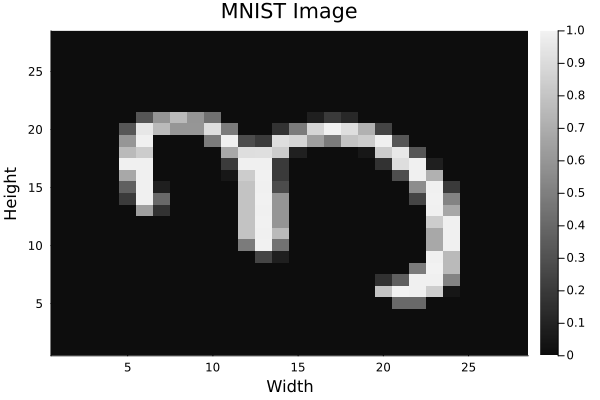

In [26]:
# Get the first batch from the test dataloader
x_batch = first(test_dataloader)[1]

# Extract the first sample and reshape it to 28×28×1×1
single_sample = x_batch[:, :, :, 30]

println("Shape of single sample: ", size(single_sample))

heatmap(single_sample[:, :, 1], c=:grays, title="MNIST Image", xlabel="Width", ylabel="Height")

In [27]:
# Pass the sample through the model
simple_chains_model(single_sample, ps, st)|>println
println(first(simple_chains_model(single_sample, ps, st)))
println(Array(first(simple_chains_model(single_sample, ps, st))))
predicted_class = onecold(Array(first(simple_chains_model(single_sample, ps, st))))
println(predicted_class)
println("Predicted class: ", predicted_class-1)

(Float32[-4.3476872, -1.7407823, 2.051219, 13.556503, -5.361658, 5.983844, -10.043649, -1.5294975, 2.930048, 2.6877203], NamedTuple())
Float32[-4.3476872, -1.7407823, 2.051219, 13.556503, -5.361658, 5.983844, -10.043649, -1.5294975, 2.930048, 2.6877203]
Float32[-4.3476872, -1.7407823, 2.051219, 13.556503, -5.361658, 5.983844, -10.043649, -1.5294975, 2.930048, 2.6877203]
4
Predicted class: 3


In [ ]:
Array(first(simple_chains_model(single_sample, ps, st)))

In [ ]:
methods(simple_chains_model)

In [ ]:
onecold(Array(first(simple_chains_model(single_sample, ps, st))))

In [ ]:
const lossfn = CrossEntropyLoss(; logits=Val(true))

function accuracy(model, ps, st, dataloader)
    total_correct, total = 0, 0
    st = Lux.testmode(st)
    for (x, y) in dataloader
        target_class = onecold(Array(y))
        predicted_class = onecold(Array(first(model(x, ps, st))))
        total_correct += sum(target_class .== predicted_class)
        total += length(target_class)
    end
    return total_correct / total
end

In [ ]:
input_data = reshape(imgs[:, :, 1], 28, 28, 1, 1)  # Reshape input to match model dimensions
output = simple_chains_model(input_data[1], ps, st)  # Pass input, parameters, and states
predicted_class = onecold(Array(output))  # Convert output to class predictions
println("Predicted class: ", predicted_class)

In [ ]:
input_data = reshape(imgs, 28,28, 1,1);

In [ ]:
output = lux_model(input_data, ps, st)
onecold(Array(first(lux_model(input_data, ps, st))))

# Otro tutorial más básico para regresión lineal

https://lux.csail.mit.edu/stable/tutorials/beginner/1_Basics

# Construcción de redes a la medida

In [5]:
myleakyrelu(x) = leakyrelu(x,0.1)

myleakyrelu (generic function with 1 method)

In [15]:
model = Chain(
    Dense(100,64),
    Dense(64,32),
    Dense(32,60,myleakyrelu)
)

Chain(
    layer_1 = Dense(100 => 64),         # 6_464 parameters
    layer_2 = Dense(64 => 32),          # 2_080 parameters
    layer_3 = Dense(32 => 60, myleakyrelu),  # 1_980 parameters
)         # Total: 10_524 parameters,
          #        plus 0 states.

In [16]:
# Initialize the model parameters and states
rng = Random.default_rng()  # Random number generator
ps, st = Lux.setup(rng, model)

((layer_1 = (weight = Float32[0.10352688 -0.13622232 … -0.13522598 0.042364527; 0.16210915 -0.09655052 … -0.09435268 -0.00455735; … ; -0.112564944 -0.019081797 … 0.028995294 0.08768993; -0.093338296 -0.07432142 … -0.027742663 0.11391579], bias = Float32[0.0988616, -0.06597085, 0.051511418, 0.08481105, 0.06113578, 0.0030281662, -0.005117762, 0.017067324, -0.074519835, 0.008899903  …  0.060148716, 0.07230755, -0.03734485, -0.07037457, -0.033323873, 0.083219185, -0.06287322, -0.08913145, -0.012587428, -0.0059464453]), layer_2 = (weight = Float32[0.20940149 -0.18485932 … 0.028108064 0.14004573; 0.02464024 -0.11213382 … 0.080270514 0.10077278; … ; -0.14969036 -0.0611886 … 0.12662314 0.016633416; -0.12468006 -0.1767973 … -0.063155726 0.18682766], bias = Float32[-0.047455564, -0.11471121, 0.11176817, 0.03912872, 0.09356171, -0.12394701, 0.10666439, -0.0938106, 0.048186496, 0.012283817  …  0.03913632, 0.0009008795, -0.074827686, -0.030892417, -0.10633063, -0.0011161566, -0.10773206, 0.10966921

In [17]:
# Let's create a dummy input tensor
batch_size = 10  # Example batch size
dummy_input = rand(Float32, 100, batch_size)  # A random matrix of size (100, batch_size)

# Pass the dummy input through the model
output = model(dummy_input, ps, st)

output[1]

60×10 Matrix{Float32}:
 -0.081954     -0.0272796    0.119514    …  -0.0331385   -0.00476939
 -0.00982197   -0.0298011   -0.0473143      -0.00323218  -0.0379501
 -0.0499227    -0.0660041   -0.0619845      -0.0835512   -0.0524041
  0.123114      0.0569579   -0.013561        0.00596754  -0.00749591
 -0.000989117   0.0947625    0.0289863       0.147181    -0.0203088
  0.477646      0.999042     0.535689    …   0.797498     0.809908
 -0.0864467    -0.0873016   -0.102056       -0.0748146   -0.126354
 -0.0542736    -0.00575387  -0.00806565     -0.0365095   -0.0283662
  0.19137      -0.0235022   -0.0211067      -0.0472742    0.286201
 -0.077306     -0.0800134   -0.0662546      -0.139733    -0.0520403
  ⋮                                      ⋱               
 -0.15014      -0.141449    -0.178714       -0.168485    -0.140754
 -0.00901049   -0.0390663   -0.0790565      -0.0555149   -0.0492741
  1.01223       0.510324     0.558509        0.295495     0.931845
  0.0398053    -0.010863    -0.0071548